In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
from tqdm import tqdm

import sys
sys.path.append('D:\diplom_2\my_test')
import my_funcs as mf

import my_thermal_funcs as mtf

## STENCIL-NET

In [2]:
import torch
import torch.nn as nn

from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from stencilnet import MLPConv, forward_rk3_error, backward_rk3_error#,backward_rk3_tvd_error,forward_rk3_tvd_error
from stencilnet import forward_rk1_error,backward_rk1_error
from utils import load_simulation_model

##### 0. Mesh Params

In [3]:
generate_flg=True # True - генерация, False - чтение уже сгенерированных
# generate_flg=False

n=41 #число узлов
L=1 # длина расчт области
T=.3 #конечное время
kurant=0.5

h=L/(n-1)
b=(n-1)*0.1*L #width % of L (длина участка с v=1, составляет 10% от расчт области)
# IC
v=[0 for i in range(0,n)]
# v=[np.sin(6.6*np.pi*i/n) for i in range(0,n)] #sin(6.6x)
# BC
v[0]=0
v[-1]=1

##### 1. Study params

In [4]:
main_params=pd.read_excel('init_params.xlsx',dtype={'has_backward':bool})
main_params=main_params.set_index('param')
display(main_params)

,value
param,
seed,1
method,RK3
decay_const,0.9
train_split,0.5
m,4
epochs,1000
l_wd,0.0
fs,2
neurons,64


In [5]:
#------------------------MAIN PARAMS-----------------------------
# size of filter to be applied
fs = int(main_params.loc['fs'])

# number of timesteps to be predicted during training 
m = int(main_params.loc['m'])

# decaying weights
decay_const = float(main_params.loc['decay_const'])

# epoch_number
epochs=int(main_params.loc['epochs'])

#random_seed
seed = int(main_params.loc['seed'])

#coef для loss функции
l_wd= float(main_params.loc['l_wd'])

# 'RK3' for runge-kutta solver and 'E1' for euler solver
method=str(main_params.loc['method'].values[0]) 

#neurons num in MLPConv
neurons=int(main_params.loc['neurons'])

#learning_rate
lr=float(main_params.loc['lr'])

#train_size
train_split=float(main_params.loc['train_split'])

# on/off bwd
has_backward=eval(main_params.loc['has_backward'].values[0])

#hidden_layers_num
hidden_layers_num=int(main_params.loc['hidden_layers_num'])

#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
print(1/100/100*0.5)

5e-05


##### 2. Generate data

In [7]:
CUSTOM_TAU=kurant*h**2#0.009
# CUSTOM_TAU=0.01
v_fact,x_lst,tau,time_lst=mtf.generate_data(generate_flg,v,T,L,0.5,h,n,CUSTOM_TAU=CUSTOM_TAU,save_flg=True)

Генерация данных
962 41
41 962


In [8]:
v_fact.shape

(41, 962)

##### 2.2 view dynamic of solution

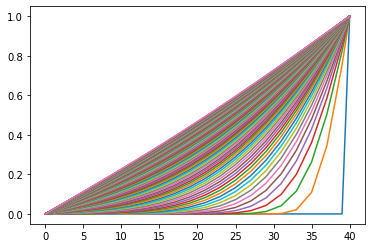

In [9]:
for j in range(0,len(v_fact[0,:]),10):
# for j in range(0,2,1):
    plt.plot(v_fact[:,j])

Text(0.5, 1.0, 'Фактические данные')

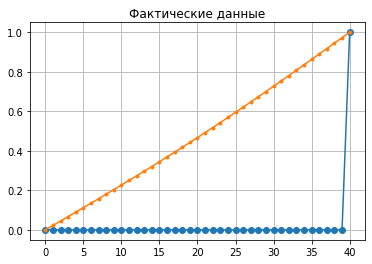

In [10]:
#view
plt.plot(v_fact[:,0],'o-')
plt.plot(v_fact[:,-1],'.-')
plt.grid()
plt.title('Фактические данные')

##### 3.Subsample Data

In [11]:
t_factor = 10  # time subsample factor 
s_factor = 4   # space subsample factor
Tsim=len(v_fact[0])
dxc,dtc,coarse_t,coarse_x,v_coarse,Lxc,\
Ltc,v_coarse_train,v_coarse_test=mf.subsampling(s_factor,t_factor,h,tau,Tsim,n,v_fact,train_split=train_split)

full_sample (11, 97)
train (11, 48)
test (11, 49)


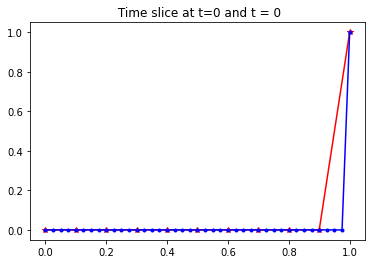

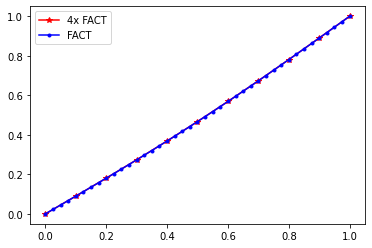

In [12]:
plt.figure()
time=0 #first time
plt.title(" Time slice at t=0 and t = " + str(time))
plt.plot(x_lst[coarse_x],v_coarse[:,time],'*-',color='red',label=str(s_factor) + 'x FACT')
plt.plot(x_lst,v_fact[:,t_factor*time],'.-',color='blue',label='FACT')
plt.figure()
time=v_coarse.shape[1]-1 #last time
plt.plot(x_lst[coarse_x],v_coarse[:,time],'*-',color='red',label=str(s_factor) + 'x FACT')
plt.plot(x_lst,v_fact[:,t_factor*time],'.-',color='blue',label='FACT')
plt.legend()
plt.show()

##### 4. Trainig model

In [13]:
fs

2

In [14]:
net, loss_lst,loss=mf.train_net(MLPConv,v_coarse_train,epochs,dtc,
              fs,
              neurons,
              hidden_layers_num,
              lr,
              m,
              has_backward,
              method,
              decay_const
             )

#test addition of test_loss
# net, loss_lst,loss=mf.train_net(MLPConv,v_coarse,epochs,dtc,
#               fs,
#               neurons,
#               lr,
#               m,
#               has_backward,
#               hidden_layers_num)



input 2 output 64
input 64 output 64
input 64 output 64
input 64 output 1
#parameters: 8577


100%|████████████████████████████████████████████████| 1000/1000 [02:10<00:00,  7.66it/s, loss=7.21e-5]


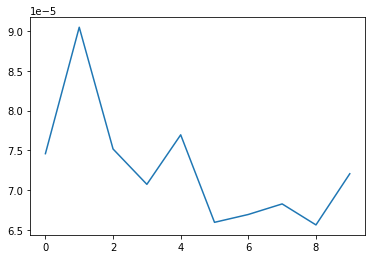

In [15]:
plt.plot(np.array(loss_lst)[:,3][-10:])

In [16]:
np.mean(np.array(loss_lst)[:,3][-10:])

7.267572218552231e-05

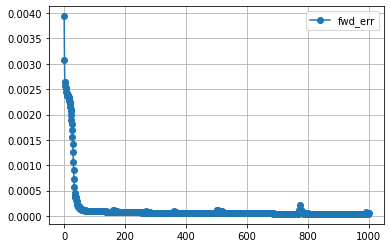

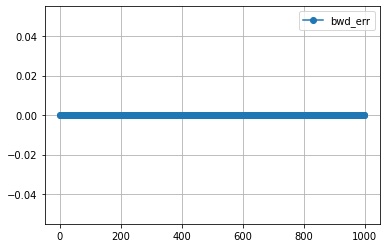

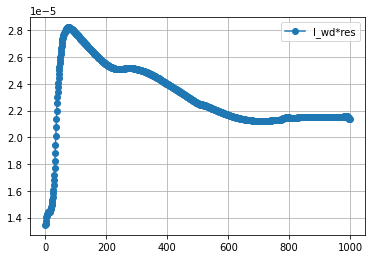

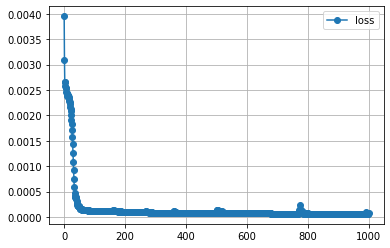

In [17]:
mf.plot_err_and_components_of_err(np.array(loss_lst))

#### temp: test _preprocess()

In [18]:
def _preprocess(x):
        """Prepares filters for forward pass."""
        x  = x.unsqueeze(-1) # Добавляет новую размерность в конец
        px = x.clone()
        
        if fs%2!=0:
            for i in range(1, int(fs/2)+1):
                r = torch.roll(x, (-1)*i, 1) # сдвигает значения тензора влево
                l = torch.roll(x, i, 1) # сдвигает значения тензора вправо
                px = torch.cat([l, px, r], -1) # объединяет 3 тензора

        elif fs%2==0 and fs!=0:
            for i in range(1, int((fs+1)/2)+1):
                r = torch.roll(x, (-1)*i, 1) # сдвигает значения тензора влево
                l = torch.roll(x, i, 1) # сдвигает значения тензора вправо
                # px=torch.zeros(px.shape)
                px = torch.cat([l, px, r], -1) # объединяет 3 тензора
                # px = torch.cat([l, r], -1)

            new_indexes=[i for i in range(int(fs/2))]+[i for i in range(int(fs/2)+1,fs+1)]
            print('px_shape',px.shape)
            print(px)
            px=px[:,:,new_indexes]
            print('px_shape',px.shape)
            print(px)
            print(new_indexes)
        else:
            raise "Non-correct 'fs' parameter"
        # return px
        pass

In [19]:
print(v_coarse_train[:,0])
test_tensor=torch.tensor(v_coarse_train.T, requires_grad=True, dtype=torch.float, device=device)
print(test_tensor[[0]])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],
       grad_fn=<IndexBackward0>)


In [20]:
_preprocess(test_tensor[[0]])

px_shape torch.Size([1, 11, 3])
tensor([[[1., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 1.],
         [0., 1., 0.]]], grad_fn=<CatBackward0>)
px_shape torch.Size([1, 11, 2])
tensor([[[1., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 1.],
         [0., 0.]]], grad_fn=<IndexBackward0>)
[0, 2]


In [21]:
test_tensor

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.1719e-02, 2.2656e-01, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 9.5367e-07,
         2.2125e-04, 7.1974e-03, 7.8354e-02, 3.8331e-01, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 2.9802e-08, 4.6492e-06, 1.9220e-04,
         3.3269e-03, 2.9449e-02, 1.4961e-01, 4.7313e-01, 1.0000e+00],
        [0.0000e+00, 7.8398e-10, 1.0258e-07, 4.8736e-06, 1.1222e-04, 1.4505e-03,
         1.1508e-02, 5.9584e-02, 2.1102e-01, 5.3271e-01, 1.0000e+00],
        [0.0000e+00, 1.2113e-07, 3.3888e-06, 5.7038e-05, 6.2104e-04, 4.6013e-03,
         2.4093e-02, 9.1915e-02, 2.6244e-01, 5.7585e-01, 1.0000e+00],
        [0.0000e+00, 1.9669e-06, 2.7192e-05, 2.6428e-04, 1.8681e-03, 9.8534e-03,
         3.96

##### 5. save_model

In [22]:
# torch.save(net, './data/models/model_thermal_n=' +str(n)+'_'+ str(fs) + "_"+str(t_factor) +'L_' + str(neurons) + '_ep_' + str(epochs)  + '_' + "elu" + '_m' + str(m) + '_Lxc' +  str(s_factor) + "_Ltc" + str(t_factor) +  '_lwd' + str(l_wd) +fr'_WDact{method}_seed_'+ str(seed)  + '.pth')

##### 6. load_model

In [23]:
# neurons = 64
# fs=7
# epochs=100
# m=4
# l_wd=0#1e-3
# seed=1
#method='E1'

# net = load_simulation_model(s_factor, t_factor, neurons, device)

# net=torch.load('./models/model_thermal_n=' +str(n)+'_' + str(fs) + "_"+str(t_factor) +'L_' + str(neurons) + '_ep_' + str(epochs)  + '_' + "elu" + '_m' + str(m) + '_Lxc' +  str(s_factor) + "_Ltc" + str(t_factor) +  '_lwd' + str(l_wd) +fr'_WDact{method}_seed_'+ str(seed)  + '.pth')

##### 7. Simulation

In [24]:
NN_sim,T_sim,x_sim=mf.make_simulation(net,v_coarse,L,Lxc,dtc)

RK3


100%|████████████████████████████████████████████████████████████████| 96/96 [00:00<00:00, 1001.54it/s]


##### 8. view_results

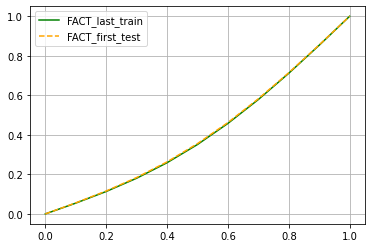

In [25]:
mf.view_train_test_graph(x_sim,v_coarse_train,v_coarse_test)

In [26]:
my_doc_params={'fs':[fs]}
mf.make_param_table(net,my_doc_params,tau,h,n,t_factor,s_factor)

,Parameter,Value
0,fs,[2]
1,neurons,64
2,hidden_layers_num,3
3,act_func,ELU(alpha=1.0)
4,epoch,1000
5,lr,0.01
6,tau,0.000313
7,h,0.025
8,n,41
9,decay_const,0.9


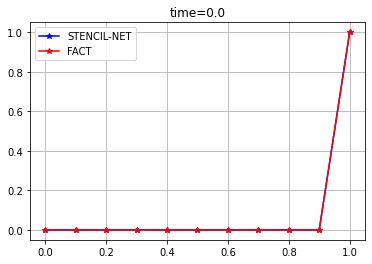

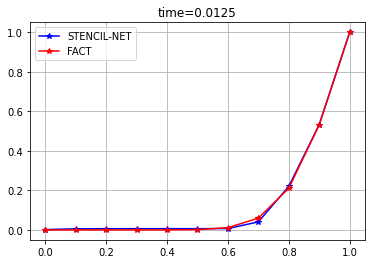

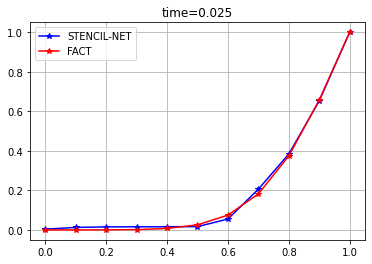

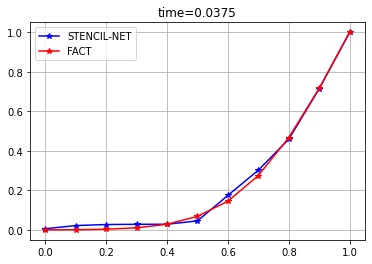

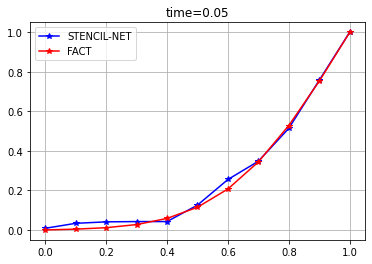

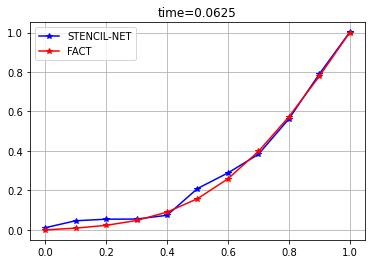

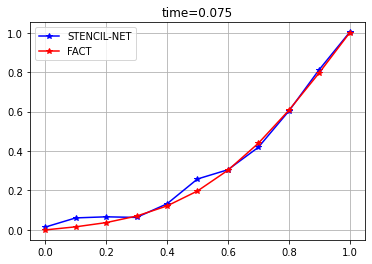

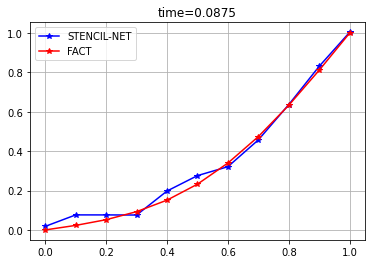

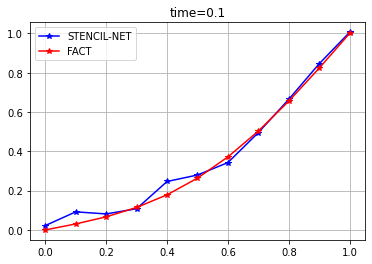

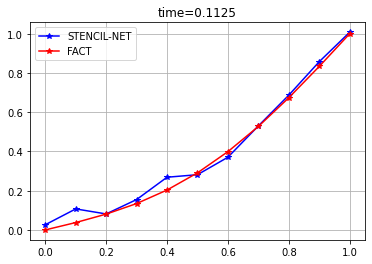

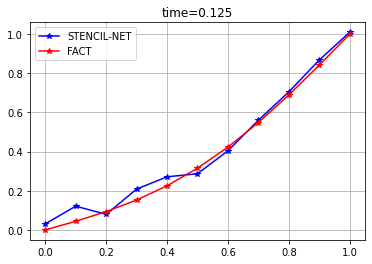

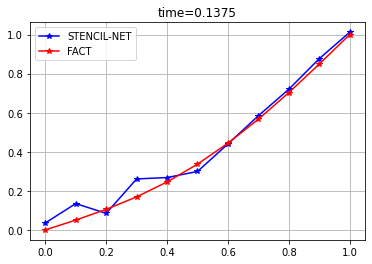

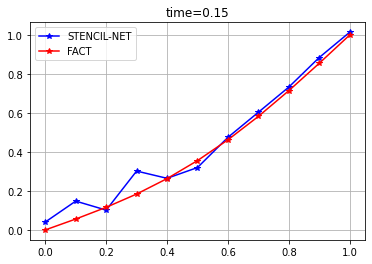

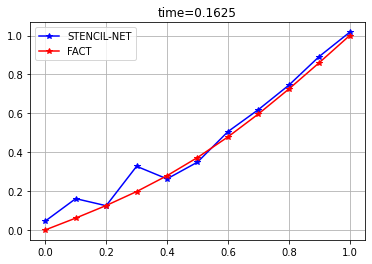

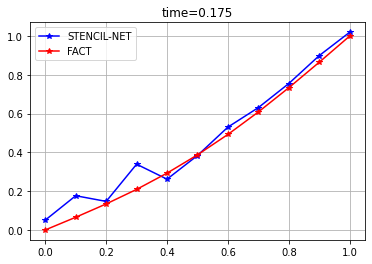

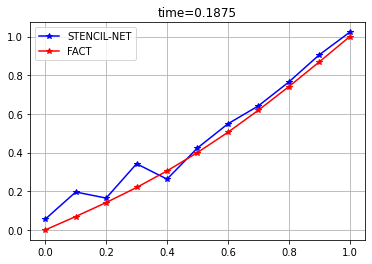

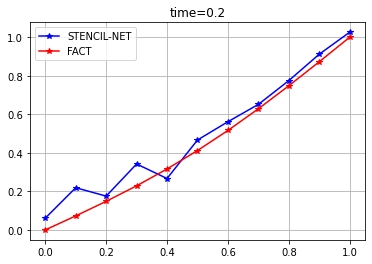

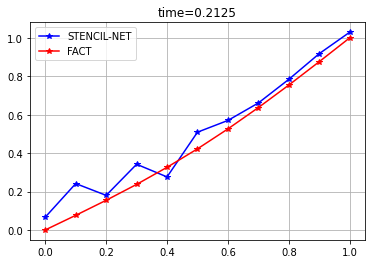

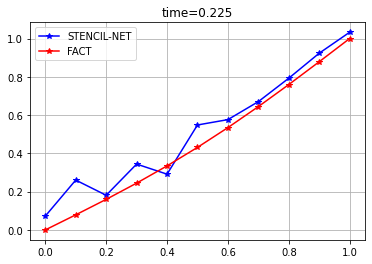

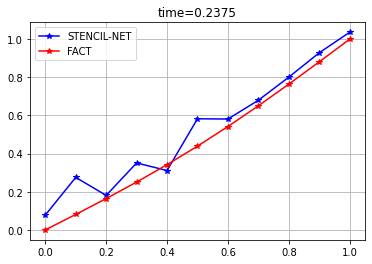

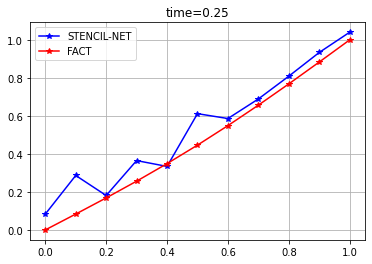

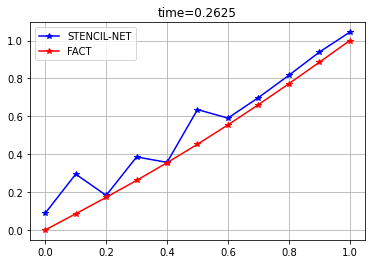

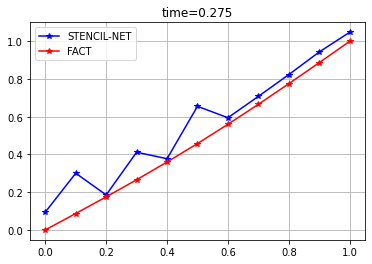

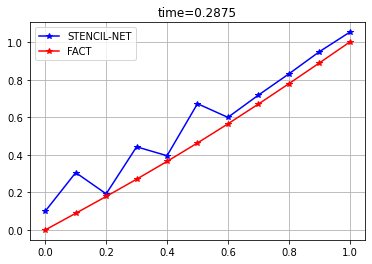

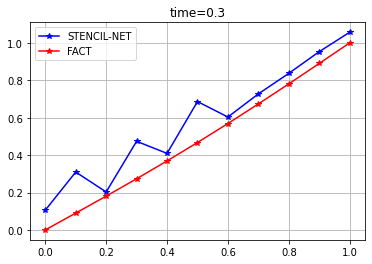

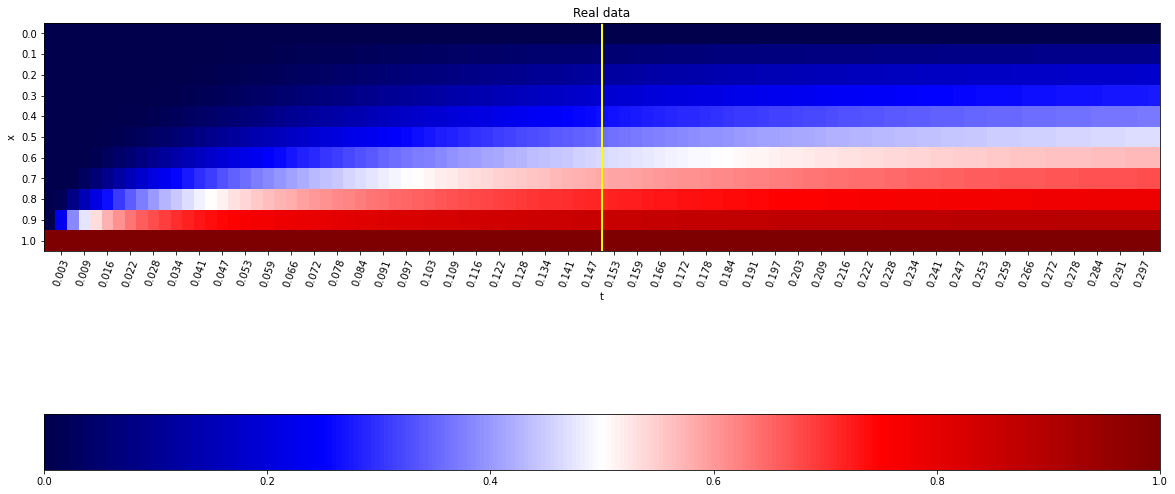

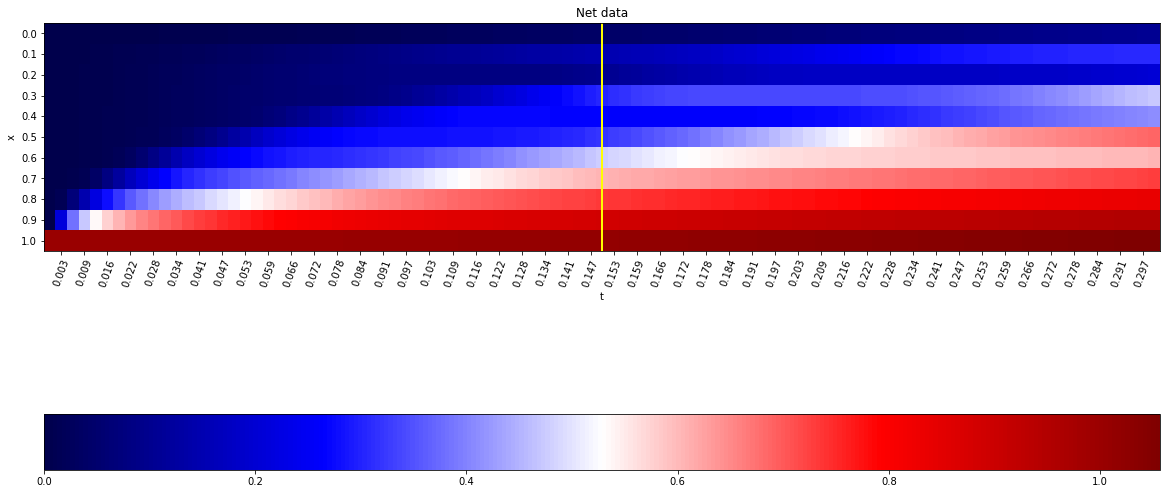

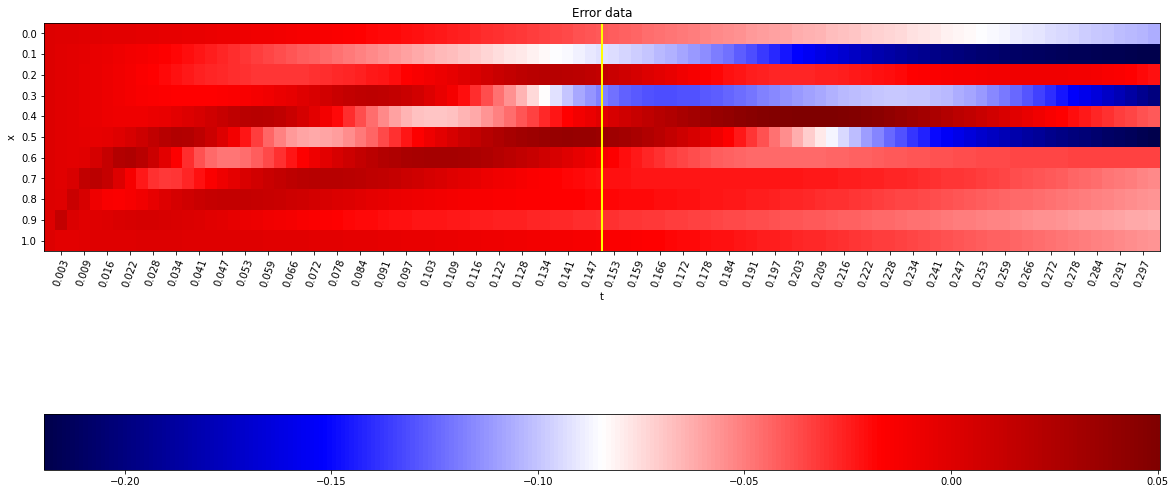

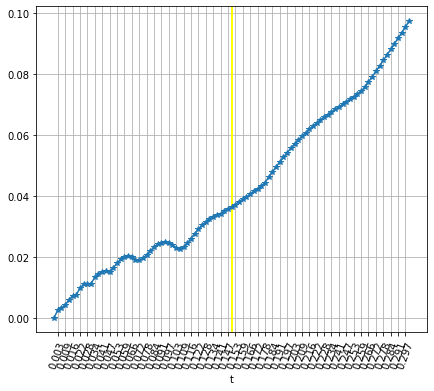

In [28]:
mf.view_results(T_sim,x_sim,NN_sim,v_coarse,T,dtc,n=25)

mf.view_result_imshow(NN_sim,v_coarse,T,dtc,L,dxc,figsize=(20,20))

mf.view_result_metric(NN_sim,v_coarse,T,dtc,L,dxc)